In [1]:
import pandas as pd
file_name = "test_out/default_post_01_001.csv"
df = pd.read_csv(file_name)[['post', 'config.algo', 'config.env_name', 'ureward_mean', 'ureward_std', 'mdim_mean', 'cdim_mean', 'mdim_nan_mean', 'mdim_std', 'nreward_mean', 'nreward_std', 'len_mean',
                             'cdim_nan_mean']]#, 'config.post']]
df

,post,config.algo,config.env_name,ureward_mean,ureward_std,mdim_mean,cdim_mean,mdim_nan_mean,mdim_std,nreward_mean,nreward_std,len_mean,cdim_nan_mean
0,iden,ppo,Walker2DBulletEnv-v0,2111.364508,10.776165,1.560541,5.336190,1.560541,0.145203,33.376486,0.170349,1000.0,5.336190
1,iden,td3,Walker2DBulletEnv-v0,2052.887746,568.973756,1.296572,10.881104,1.296572,0.192960,2052.887692,568.973735,917.5,10.881104
2,iden,sac,Walker2DBulletEnv-v0,2064.071153,681.336737,1.267627,10.661319,1.267627,0.276100,2064.071131,681.336729,901.5,10.661319
3,iden,tqc,Walker2DBulletEnv-v0,2418.166841,755.757666,1.305009,9.415485,1.305009,0.128889,2418.166795,755.757647,907.8,9.415485
4,iden,ppo,HalfCheetahBulletEnv-v0,2908.169612,38.828683,1.573944,5.134705,1.573944,0.093851,26.925796,0.359502,1000.0,5.134705
5,iden,td3,HalfCheetahBulletEnv-v0,2826.124755,14.489177,1.374065,8.956402,1.374065,0.082803,2826.124731,14.489161,1000.0,8.956402
6,iden,sac,HalfCheetahBulletEnv-v0,2793.418870,8.802347,1.159261,8.502494,1.159261,0.097310,2793.418774,8.802360,1000.0,8.502494
7,iden,tqc,HalfCheetahBulletEnv-v0,3683.604083,17.602738,1.454502,5.840621,1.454502,0.065291,3683.604077,17.602688,1000.0,5.840621
8,iden,ppo,HopperBulletEnv-v0,2537.098882,263.534898,1.433970,4.877648,1.433970,0.085089,29.168804,3.029838,966.4,4.877648
9,iden,td3,HopperBulletEnv-v0,2679.315193,28.479300,1.240117,6.282698,1.240117,0.086367,2679.315210,28.479283,998.0,6.282698


(2000.0, 4000.0)

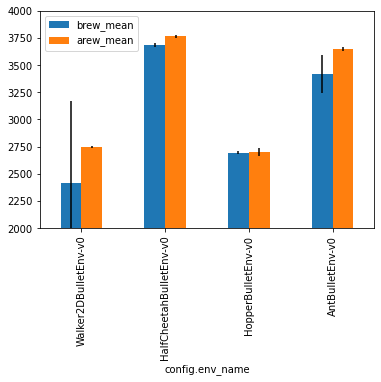

In [35]:
df2 = pd.DataFrame()
df2['config.env_name'] = df[df['post'] == 'iden']['config.env_name']
df2['config.algo'] = df[df['post'] == 'iden']['config.algo']
df2['brew_mean'] = df[df['post'] == 'iden']['ureward_mean']
df2['brew_std'] = df[df['post'] == 'iden']['ureward_std']
df2['arew_mean'] = df[df['post'] == 'postprocess_default']['ureward_mean'].to_numpy()
df2['arew_std'] = df[df['post'] == 'postprocess_default']['ureward_std'].to_numpy()

df2.drop(df2[df2['config.env_name'] == 'ReacherBulletEnv-v0'].index, inplace=True)



dfp = df2[df2['config.algo'] == 'tqc']
dfp.plot.bar(x='config.env_name', y=['brew_mean', 'arew_mean'], yerr={'brew_mean':dfp['brew_std'], 'arew_mean':dfp['arew_std']})
plt.ylim(2000, 4000)

In [63]:
algo='td3'
df[(df['post'] == 'iden') & (df['config.algo'] == algo) ]

,post,config.algo,config.env_name,ureward_mean,ureward_std,mdim_mean,cdim_mean,mdim_nan_mean,mdim_std,nreward_mean,nreward_std,len_mean,cdim_nan_mean
1,iden,td3,Walker2DBulletEnv-v0,2052.887746,568.973756,1.296572,10.881104,1.296572,0.192960,2052.887692,568.973735,917.5,10.881104
5,iden,td3,HalfCheetahBulletEnv-v0,2826.124755,14.489177,1.374065,8.956402,1.374065,0.082803,2826.124731,14.489161,1000.0,8.956402
9,iden,td3,HopperBulletEnv-v0,2679.315193,28.479300,1.240117,6.282698,1.240117,0.086367,2679.315210,28.479283,998.0,6.282698
13,iden,td3,AntBulletEnv-v0,3313.426100,41.518409,1.710029,9.815890,1.710029,0.101798,3313.426123,41.518435,1000.0,9.815890
17,iden,td3,ReacherBulletEnv-v0,12.441167,5.627356,0.634532,4.283022,0.634532,0.090405,12.441167,5.627355,150.0,4.283022


In [64]:
df[(df['post'] == 'postprocess_default') & (df['config.algo'] == algo) ]

,post,config.algo,config.env_name,ureward_mean,ureward_std,mdim_mean,cdim_mean,mdim_nan_mean,mdim_std,nreward_mean,nreward_std,len_mean,cdim_nan_mean
21,postprocess_default,td3,Walker2DBulletEnv-v0,2449.883711,9.399407,1.249671,11.916661,1.249671,0.087513,2449.883789,9.399403,1000.0,11.916661
25,postprocess_default,td3,HalfCheetahBulletEnv-v0,2954.047030,12.790530,1.151075,9.411630,1.151075,0.108290,2954.047046,12.790509,1000.0,9.411630
29,postprocess_default,td3,HopperBulletEnv-v0,2849.498259,11.254691,1.303436,7.082571,1.303436,0.049567,2849.498267,11.254670,998.6,7.082571
33,postprocess_default,td3,AntBulletEnv-v0,3443.013020,15.873944,1.523520,8.559933,1.523520,0.119517,3443.012988,15.873920,1000.0,8.559933
37,postprocess_default,td3,ReacherBulletEnv-v0,12.393237,5.586584,0.623266,4.359015,0.623266,0.080227,12.393237,5.586585,150.0,4.359015
